In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tqdm import tqdm
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)


In [3]:
RAW_DATA_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\fer2013")
TRAIN_DIR = RAW_DATA_DIR / 'train'
TEST_DIR = RAW_DATA_DIR / 'test'

PROCESSED_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\processed\emotions")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\results\emotion_preprocessing")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

EMOTION_LABELS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
EMOTION_TO_ID = {emotion: idx for idx, emotion in enumerate(EMOTION_LABELS)}
ID_TO_EMOTION = {idx: emotion for emotion, idx in EMOTION_TO_ID.items()}

IMG_SIZE = (48, 48)
VAL_SPLIT = 0.15

print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Processed data will be saved to: {PROCESSED_DIR}")
print(f"\nEmotion labels: {EMOTION_LABELS}")
print(f"Number of classes: {len(EMOTION_LABELS)}")


Train directory: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\fer2013\train
Test directory: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\fer2013\test
Processed data will be saved to: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\processed\emotions

Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
Number of classes: 7


## Load Dataset

In [4]:
def load_emotion_dataset(data_dir):
    dataset = []

    for emotion in os.listdir(data_dir):
        emotion_path = os.path.join(data_dir, emotion)

        if os.path.isdir(emotion_path) and emotion in EMOTION_LABELS:
            for img_name in os.listdir(emotion_path):
                if img_name.endswith(('.jpg', '.png')):
                    img_path = os.path.join(emotion_path, img_name)
                    dataset.append({
                        'path': img_path,
                        'emotion': emotion,
                        'emotion_id': EMOTION_TO_ID[emotion]
                    })

    return pd.DataFrame(dataset)

print("Loading datasets...")
train_df = load_emotion_dataset(TRAIN_DIR)
test_df = load_emotion_dataset(TEST_DIR)

print(f"\n=== DATASET LOADED ===")
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

print(f"\nTrain set distribution:")
print(train_df['emotion'].value_counts().sort_index())

train_df.head()


Loading datasets...

=== DATASET LOADED ===
Train samples: 28709
Test samples: 7178
Total samples: 35887

Train set distribution:
emotion
angry       3995
disgust      436
fear        4097
happy       7215
neutral     4965
sad         4830
surprise    3171
Name: count, dtype: int64


,path,emotion,emotion_id
0,C:\Users\MSI GF66\OneDrive - National Polyechn...,angry,0
1,C:\Users\MSI GF66\OneDrive - National Polyechn...,angry,0
2,C:\Users\MSI GF66\OneDrive - National Polyechn...,angry,0
3,C:\Users\MSI GF66\OneDrive - National Polyechn...,angry,0
4,C:\Users\MSI GF66\OneDrive - National Polyechn...,angry,0


## Calculate Class Weights

=== CLASS WEIGHTS (for handling imbalance) ===
Angry        (ID 0): 1.027
Disgust      (ID 1): 9.407
Fear         (ID 2): 1.001
Happy        (ID 3): 0.568
Sad          (ID 4): 0.849
Surprise     (ID 5): 1.293
Neutral      (ID 6): 0.826


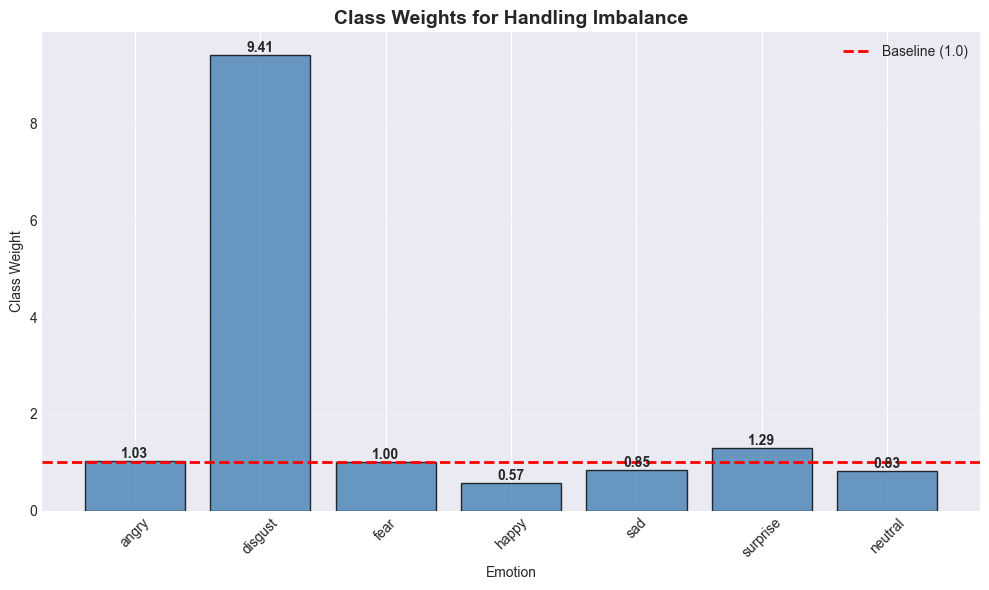

In [5]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['emotion_id']),
    y=train_df['emotion_id']
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("=== CLASS WEIGHTS (for handling imbalance) ===")
for emotion_id, weight in class_weight_dict.items():
    emotion_name = ID_TO_EMOTION[emotion_id]
    print(f"{emotion_name.capitalize():12s} (ID {emotion_id}): {weight:.3f}")

fig, ax = plt.subplots(figsize=(10, 6))
emotions = [ID_TO_EMOTION[i] for i in range(len(EMOTION_LABELS))]
weights = [class_weight_dict[i] for i in range(len(EMOTION_LABELS))]

bars = ax.bar(emotions, weights, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Emotion')
ax.set_ylabel('Class Weight')
ax.set_title('Class Weights for Handling Imbalance', fontsize=14, fontweight='bold')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar, weight in zip(bars, weights):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{weight:.2f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'class_weights.png', dpi=300, bbox_inches='tight')
plt.show()



## Image Loading and Normalization

In [6]:
def load_and_normalize_image(img_path, normalize='standard'):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    if img.shape != IMG_SIZE:
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

    img = img.astype(np.float32)
    if normalize == 'standard':
        img = img / 255.0
    elif normalize == 'centered':
        img = (img - 127.5) / 127.5
    elif normalize == 'standardize':
        img = (img - np.mean(img)) / (np.std(img) + 1e-7)

    return np.expand_dims(img, axis=-1)


## Splitting

In [7]:
train_data, val_data = train_test_split(
    train_df,
    test_size=VAL_SPLIT,
    random_state=42,
    stratify=train_df['emotion']
)

print(f"Train set: {len(train_data)}")
print(f"Validation set: {len(val_data)}")
print(f"Test set: {len(test_df)}")


Train set: 24402
Validation set: 4307
Test set: 7178


## Process and Save

In [8]:
def build_image_array(df, normalize='standard'):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
        img = load_and_normalize_image(row['path'], normalize=normalize)
        if img is not None:
            X.append(img)
            y.append(row['emotion_id'])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    return X, y

print("\nLoading and normalizing training images...")
X_train, y_train = build_image_array(train_data, normalize='standard')

print("\nLoading and normalizing validation images...")
X_val, y_val = build_image_array(val_data, normalize='standard')

print("\nLoading and normalizing test images...")
X_test, y_test = build_image_array(test_df, normalize='standard')

print(f"\n=== Dataset Shapes ===")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")



Loading and normalizing training images...


Processing images: 100%|██████████| 24402/24402 [00:11<00:00, 2127.45it/s]



Loading and normalizing validation images...


Processing images: 100%|██████████| 4307/4307 [00:01<00:00, 2155.04it/s]



Loading and normalizing test images...


Processing images: 100%|██████████| 7178/7178 [00:02<00:00, 2501.20it/s]


=== Dataset Shapes ===
X_train: (24402, 48, 48, 1), y_train: (24402,)
X_val:   (4307, 48, 48, 1), y_val:   (4307,)
X_test:  (7178, 48, 48, 1), y_test:  (7178,)


In [9]:
metadata = {
    "dataset_name": "FER2013",
    "image_size": IMG_SIZE,
    "color_mode": "grayscale",
    "num_classes": len(EMOTION_LABELS),
    "class_labels": EMOTION_LABELS,
    "emotion_to_id": EMOTION_TO_ID,
    "id_to_emotion": ID_TO_EMOTION,
    "train_samples": len(X_train),
    "val_samples": len(X_val),
    "test_samples": len(X_test),
    "normalization": "standard",
    "val_split": VAL_SPLIT,
    "class_weights": class_weight_dict,
    "source_directories": {
        "train": str(TRAIN_DIR),
        "test": str(TEST_DIR)
    }
}

for k, v in metadata.items():
    if isinstance(v, dict):
        print(f"{k:20s}: {{...}} ({len(v)} items)")
    else:
        print(f"{k:20s}: {v}")


dataset_name        : FER2013
image_size          : (48, 48)
color_mode          : grayscale
num_classes         : 7
class_labels        : ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion_to_id       : {...} (7 items)
id_to_emotion       : {...} (7 items)
train_samples       : 24402
val_samples         : 4307
test_samples        : 7178
normalization       : standard
val_split           : 0.15
class_weights       : {...} (7 items)
source_directories  : {...} (2 items)


In [10]:
np.save(PROCESSED_DIR / 'X_train.npy', X_train)
np.save(PROCESSED_DIR / 'y_train.npy', y_train)
np.save(PROCESSED_DIR / 'X_val.npy', X_val)
np.save(PROCESSED_DIR / 'y_val.npy', y_val)
np.save(PROCESSED_DIR / 'X_test.npy', X_test)
np.save(PROCESSED_DIR / 'y_test.npy', y_test)

with open(PROCESSED_DIR / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
